### GRACE/GRACE-FO Terrestrial Water Storage in the Okavango Delta and Angola Highlands 

- Load GRACE/GRACE-FO monthly land water-equivalent (LWE) time series for the Angola highlands “watertower” and the Okavango Delta, adding year and sorting by date.

- Plot monthly LWE with ±1σ bands and explore temporal persistence using autocorrelation functions for both regions.

- Fit a single-period (12-month) harmonic to the GRACE LWE series to describe the seasonal cycle and derive annual mean storage for highlands and delta.

- Normalize and compare GRACE-based storage metrics with July–September (JAS) flood extent from Landsat DSWE and Inman–Lyons annual flood-area estimates.

In [1]:
import ee, geemap
from itertools import product

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()


In [2]:
# pip install folium shapely
import folium
from shapely.geometry import Polygon

# bbox = (min_lon, min_lat, max_lon, max_lat)
okavango_bbox = (19.0, -21.8, 24.8, -17.0)
angola_water_tower_bbox = (15.0, -15.5, 19.5, -11.0)

# Build (lon, lat) corner lists from the bounding boxes
okavango = [
    (okavango_bbox[0], okavango_bbox[3]),  # (min_lon, max_lat)
    (okavango_bbox[0], okavango_bbox[1]),  # (min_lon, min_lat)
    (okavango_bbox[2], okavango_bbox[1]),  # (max_lon, min_lat)
    (okavango_bbox[2], okavango_bbox[3]),  # (max_lon, max_lat)
]

angola_water_tower = [
    (angola_water_tower_bbox[0], angola_water_tower_bbox[3]),
    (angola_water_tower_bbox[0], angola_water_tower_bbox[1]),
    (angola_water_tower_bbox[2], angola_water_tower_bbox[1]),
    (angola_water_tower_bbox[2], angola_water_tower_bbox[3]),
]

# Center map on Okavango polygon centroid
poly_okavango = Polygon(okavango)
lat, lon = poly_okavango.centroid.y, poly_okavango.centroid.x
m = folium.Map(location=[lat, lon], zoom_start=6, tiles="CartoDB positron")

# Convert (lon, lat) -> (lat, lon) for Folium
okavango_latlon = [(lat, lon) for lon, lat in okavango]
angola_water_tower_latlon = [(lat, lon) for lon, lat in angola_water_tower]

# Okavango polygon
folium.Polygon(
    color="red",
    weight=3,
    fill=True,
    fill_opacity=0.2,
    tooltip="Okavango study area",
).add_to(m)

# Angola water tower polygon
folium.Polygon(
    locations=angola_water_tower_latlon,
    color="blue",
    weight=3,
    fill=False,
    tooltip="Angola water tower",
).add_to(m)

m




In [3]:
# pip install xarray numpy folium shapely
import xarray as xr
import numpy as np
from branca.colormap import LinearColormap

# -------------------------------------------------------------------
# 1. Open GRACE JPL RL06.3 CRI netCDF (update path to your file)
# -------------------------------------------------------------------
grace_path = "../data/grace_subsaharan_out/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc"
ds = xr.open_dataset(grace_path)

# choose a month to display
target_time = "2015-01-15"  # change as needed
ds_t = ds.sel(time=np.datetime64(target_time), method="nearest")

# -------------------------------------------------------------------
# 2. Subset to region covering both boxes
# -------------------------------------------------------------------
min_lon = min(okavango_bbox[0], angola_water_tower_bbox[0]) - 4
max_lon = max(okavango_bbox[2], angola_water_tower_bbox[2]) + 5
min_lat = min(okavango_bbox[1], angola_water_tower_bbox[1]) - 5
max_lat = max(okavango_bbox[3], angola_water_tower_bbox[3]) + 4

# handle possible descending latitude axis
lat_vals = ds_t["lat"].values
if lat_vals[0] < lat_vals[-1]:
    lat_slice = slice(min_lat, max_lat)
else:
    lat_slice = slice(max_lat, min_lat)

lon_slice = slice(min_lon, max_lon)

field = ds_t["lwe_thickness"].sel(lat=lat_slice, lon=lon_slice)

field = (
    ds["lwe_thickness"]
    .sel(lat=lat_slice, lon=lon_slice)
    .mean(dim="time", skipna=True)
)

data = field.values
lats = field["lat"].values
lons = field["lon"].values

# -------------------------------------------------------------------
# 3. Make a colormap based on GRACE values
# -------------------------------------------------------------------
vmin = float(np.nanpercentile(data, 5))
vmax = float(np.nanpercentile(data, 95))

colormap = LinearColormap(
    ["#ffffcc", "#41b6c4", "#081d58"],  # light -> dark
    vmin=vmin,
    vmax=vmax,
)
colormap.caption = "GRACE JPL RL06.3 CRI lwe_thickness (cm)"
colormap.add_to(m)

# -------------------------------------------------------------------
# 4. Plot GRACE as circle markers on the existing map `m`
# -------------------------------------------------------------------
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        val = float(data[i, j])
        if not np.isfinite(val):
            continue
        folium.CircleMarker(
            location=[float(lat), float(lon)],
            radius=3,
            weight=0,
            fill=True,
            fill_opacity=0.8,
            fill_color=colormap(val),
        ).add_to(m)

m
# Product is "GRACE JPL RL06.3 CRI lwe_thickness (cm)", effective resolution is 3 lat/lon, 
# see if we can download chirps to GRACE grid cells 


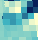

In [9]:
# pip install xarray numpy folium shapely matplotlib
import xarray as xr
import numpy as np
from branca.colormap import LinearColormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
import folium

# pip install folium shapely
import folium
from shapely.geometry import Polygon

# bbox = (min_lon, min_lat, max_lon, max_lat)
# okavango_bbox = (19.0, -21.8, 24.8, -17.0)
# angola_water_tower_bbox = (15.0, -15.5, 19.5, -11.0)

# Build (lon, lat) corner lists from the bounding boxes
okavango = [
    (okavango_bbox[0], okavango_bbox[3]),  # (min_lon, max_lat)
    (okavango_bbox[0], okavango_bbox[1]),  # (min_lon, min_lat)
    (okavango_bbox[2], okavango_bbox[1]),  # (max_lon, min_lat)
    (okavango_bbox[2], okavango_bbox[3]),  # (max_lon, max_lat)
]

angola_water_tower = [
    (angola_water_tower_bbox[0], angola_water_tower_bbox[3]),
    (angola_water_tower_bbox[0], angola_water_tower_bbox[1]),
    (angola_water_tower_bbox[2], angola_water_tower_bbox[1]),
    (angola_water_tower_bbox[2], angola_water_tower_bbox[3]),
]

# Center map on Okavango polygon centroid
poly_okavango = Polygon(okavango)
lat, lon = poly_okavango.centroid.y, poly_okavango.centroid.x
m = folium.Map(location=[lat, lon], zoom_start=6, tiles="CartoDB positron")

# Convert (lon, lat) -> (lat, lon) for Folium
okavango_latlon = [(lat, lon) for lon, lat in okavango]
angola_water_tower_latlon = [(lat, lon) for lon, lat in angola_water_tower]

# Okavango polygon
folium.Polygon(
    locations=okavango_latlon,
    color="red",
    weight=3,
    fill=False,
    fill_opacity=0.2,
    tooltip="Okavango study area",
).add_to(m)

# Angola water tower polygon
folium.Polygon(
    locations=angola_water_tower_latlon,
    color="blue",
    weight=3,
    fill=False,
    tooltip="Angola water tower",
).add_to(m)


# -------------------------------------------------------------------
# 1. Open GRACE JPL RL06.3 CRI netCDF
# -------------------------------------------------------------------
grace_path = "../data/grace_subsaharan_out/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc"
ds = xr.open_dataset(grace_path)

# choose a month to display
target_time = "2015-01-15"  # change as needed

# grab the lwe_thickness field at that time (2D: lat x lon)
field = ds["lwe_thickness"].sel(time=np.datetime64(target_time), method="nearest")

field = (
    ds["lwe_thickness"]
    .sel(lat=lat_slice, lon=lon_slice)
    .mean(dim="time", skipna=True)
)

# if longitudes are 0–360, convert to -180–180 for mapping
if field["lon"].max() > 180:
    field = field.assign_coords(lon=((field["lon"] + 180) % 360) - 180).sortby("lon")

data = field.values
lats = field["lat"].values
lons = field["lon"].values

# -------------------------------------------------------------------
# 1b. NEW: Clip GRACE field to region around your polygons
# -------------------------------------------------------------------
roi_lon_min = min(okavango_bbox[0], angola_water_tower_bbox[0]) - 4
roi_lon_max = max(okavango_bbox[2], angola_water_tower_bbox[2]) + 5
roi_lat_min = min(okavango_bbox[1], angola_water_tower_bbox[1]) - 5
roi_lat_max = max(okavango_bbox[3], angola_water_tower_bbox[3]) + 4

lat_mask = (lats >= roi_lat_min) & (lats <= roi_lat_max)
lon_mask = (lons >= roi_lon_min) & (lons <= roi_lon_max)

data = data[np.ix_(lat_mask, lon_mask)]
lats = lats[lat_mask]
lons = lons[lon_mask]

# -------------------------------------------------------------------
# 2. Prepare data orientation for ImageOverlay
#    Leaflet expects row 0 = north (max lat).
# -------------------------------------------------------------------
if lats[0] < lats[-1]:  # ascending (south → north)
    data = data[::-1, :]
    lats = lats[::-1]

# Now the bounds are the min/max of the *cropped* color plot
lat_min = float(lats.min())
lat_max = float(lats.max())
lon_min = float(lons.min())
lon_max = float(lons.max())

# (Optional) zoom map to this ROI:
# m.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

# -------------------------------------------------------------------
# 3. Create colormap & legend
# -------------------------------------------------------------------
vmin, vmax = np.nanpercentile(data, [5, 95])

colors = ["#ffffcc", "#41b6c4", "#081d58"]

colormap = LinearColormap(colors, vmin=vmin, vmax=vmax)
colormap.caption = "GRACE JPL RL06.3 CRI lwe_thickness (cm)"
colormap.add_to(m)

mpl_cmap = LinearSegmentedColormap.from_list("grace_cm", colors)
norm = Normalize(vmin=vmin, vmax=vmax)

rgba = mpl_cmap(norm(data))  # (nlat, nlon, 4)

# set NaNs to transparent
mask = np.isfinite(data)
rgba[..., -1] = mask.astype(float)

img = (rgba * 255).astype(np.uint8)

# -------------------------------------------------------------------
# 4. Add GRACE raster as an ImageOverlay onto existing map `m`
# -------------------------------------------------------------------
folium.raster_layers.ImageOverlay(
    image=img,
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],  # trimmed to color plot
    opacity=0.7,
    interactive=False,
    cross_origin=False,
    zindex=1,
).add_to(m)

from pathlib import Path
import geopandas as gpd
import folium

# --- your delta shapefile ---
delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")

# read + ensure WGS84
delta_gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)

# (optional) dissolve to a single polygon/multipolygon
delta_union = delta_gdf.dissolve()

# --- add to existing folium map `m` ---
folium.GeoJson(
    delta_union.__geo_interface__,
    name="Okavango Delta (UCB)",
    style_function=lambda feat: {
        "color": "yellow",
        "weight": 3,
        "fillColor": "yellow",
        "fillOpacity": 0.15,
    },
    tooltip="Okavango Delta polygon (UCB)",
).add_to(m)

# Optional: zoom map to delta bounds
bounds = delta_union.total_bounds  # minx, miny, maxx, maxy
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Optional: layer control if you don't already have it
folium.LayerControl(collapsed=False).add_to(m)

m

m

In [5]:
# pip install earthengine-api pandas xarray numpy shapely
import ee
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon

# ----------------------------
# 0) Earth Engine init
# ----------------------------
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ----------------------------
# 1) GRACE grid + pick a 3x3 around a region
# ----------------------------
da = ds["lwe_thickness"]  # (time, lat, lon)

dlat = float(np.median(np.abs(np.diff(da["lat"].values))))
dlon = float(np.median(np.abs(np.diff(da["lon"].values))))
print("GRACE grid step (deg):", dlat, dlon)  # likely 0.5, 0.5

def _idx3(i, n):
    """Return 3 indices centered on i, clamped to [0, n-1]."""
    if n < 3:
        raise ValueError("Need at least 3 grid points along this axis.")
    if i <= 0:
        return [0, 1, 2]
    if i >= n - 1:
        return [n - 3, n - 2, n - 1]
    return [i - 1, i, i + 1]

def grace_3x3_from_polygon(da, poly_lonlat):
    """
    Returns 9 dicts with {cell_id, lat, lon} labeled:
    NW, N, NE / W, C, E / SW, S, SE
    """
    poly = Polygon(poly_lonlat)
    lon0, lat0 = float(poly.centroid.x), float(poly.centroid.y)

    # handle 0–360 vs -180–180 lon conventions
    lon_vals = da["lon"].values
    if lon_vals.max() > 180 and lon0 < 0:
        lon0 = (lon0 + 360) % 360
    if lon_vals.max() <= 180 and lon0 > 180:
        lon0 = ((lon0 + 180) % 360) - 180

    lat_vals = da["lat"].values
    ilat = int(np.argmin(np.abs(lat_vals - lat0)))
    ilon = int(np.argmin(np.abs(lon_vals - lon0)))

    lat_idx = _idx3(ilat, len(lat_vals))
    lon_idx = _idx3(ilon, len(lon_vals))

    lat3 = [float(lat_vals[i]) for i in lat_idx]
    lon3 = [float(lon_vals[j]) for j in lon_idx]

    # sort N->S and W->E for consistent labeling
    lat_sorted = sorted(lat3, reverse=True)
    lon_sorted = sorted(lon3)

    row_tag = {lat_sorted[0]: "N", lat_sorted[1]: "C", lat_sorted[2]: "S"}
    col_tag = {lon_sorted[0]: "W", lon_sorted[1]: "C", lon_sorted[2]: "E"}

    label_map = {
        ("N","W"):"NW", ("N","C"):"N",  ("N","E"):"NE",
        ("C","W"):"W",  ("C","C"):"C",  ("C","E"):"E",
        ("S","W"):"SW", ("S","C"):"S",  ("S","E"):"SE",
    }

    cells = []
    for lat in lat_sorted:
        for lon in lon_sorted:
            cid = label_map[(row_tag[lat], col_tag[lon])]
            cells.append({"cell_id": cid, "lat": lat, "lon": lon})

    order = ["NW","N","NE","W","C","E","SW","S","SE"]
    cells = sorted(cells, key=lambda d: order.index(d["cell_id"]))
    return cells

# choose which region the 3×3 is centered on:
# - use angola_water_tower (bbox corners) or okavango (bbox corners)
cells = grace_3x3_from_polygon(da, okavango)
print("3x3 cells:", [(c["cell_id"], c["lat"], c["lon"]) for c in cells])

# build EE FeatureCollection of the 9 GRACE cell footprints
features = []
for c in cells:
    lat, lon = c["lat"], c["lon"]
    geom = ee.Geometry.Rectangle(
        [lon - dlon/2, lat - dlat/2, lon + dlon/2, lat + dlat/2],
        proj="EPSG:4326",
        geodesic=False
    )
    features.append(ee.Feature(geom, {"cell_id": c["cell_id"], "lat": lat, "lon": lon}))
fc_cells = ee.FeatureCollection(features)

# ----------------------------
# 2) CHIRPS daily -> monthly totals, reduced over each GRACE cell
# ----------------------------
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation")  # mm/day

# align months to GRACE coverage
tmin = pd.to_datetime(da["time"].values.min())
tmax = pd.to_datetime(da["time"].values.max())
start_py = pd.Timestamp(tmin.year, tmin.month, 1)
end_py   = (pd.Timestamp(tmax.year, tmax.month, 1) + pd.offsets.MonthBegin(1))  # exclusive

start = ee.Date(start_py.strftime("%Y-%m-%d"))
end   = ee.Date(end_py.strftime("%Y-%m-%d"))
n_months = end.difference(start, "month").toInt()
month_offsets = ee.List.sequence(0, n_months.subtract(1))

def monthly_img(m):
    m = ee.Number(m)
    s = start.advance(m, "month")
    e = s.advance(1, "month")
    img = chirps.filterDate(s, e).sum().rename("chirps_mm_month")  # mm/month
    return img.set({"system:time_start": s.millis(), "date": s.format("YYYY-MM-01")})

monthly = ee.ImageCollection(month_offsets.map(monthly_img))

def reduce_one(img):
    date_str = ee.String(img.get("date"))
    out = img.reduceRegions(
        collection=fc_cells,
        reducer=ee.Reducer.mean(),  # spatial mean over the GRACE cell footprint
        scale=5500                  # ~5.5 km nominal (CHIRPS 0.05°)
    )
    return out.map(lambda f: f.set({"date": date_str}))

table = monthly.map(reduce_one).flatten()

# ----------------------------
# 3) Pull to pandas + save
# ----------------------------
info = table.getInfo()
rows = [f["properties"] for f in info["features"]]
df = pd.DataFrame(rows).rename(columns={"mean": "chirps_mm_month"})
df["time"] = pd.to_datetime(df["date"])

# tidy export
out_csv = "../data/chirps_mm_month_3x3_gracecells.csv"
df[["time", "cell_id", "lat", "lon", "chirps_mm_month"]].to_csv(out_csv, index=False)
print("Wrote:", out_csv)

# handy wide table (time x cell_id)
wide = (df.pivot(index="time", columns="cell_id", values="chirps_mm_month")
          .sort_index()[["NW","N","NE","W","C","E","SW","S","SE"]])
wide.head()


GRACE grid step (deg): 0.5 0.5
3x3 cells: [('NW', -18.75, 21.25), ('N', -18.75, 21.75), ('NE', -18.75, 22.25), ('W', -19.25, 21.25), ('C', -19.25, 21.75), ('E', -19.25, 22.25), ('SW', -19.75, 21.25), ('S', -19.75, 21.75), ('SE', -19.75, 22.25)]
Wrote: chirps_mm_month_3x3_gracecells.csv


cell_id,NW,N,NE,W,C,E,SW,S,SE
time,,,,,,,,,
2002-04-01,10.975122,11.010997,13.749959,12.693987,12.493805,13.965464,13.631742,11.718803,12.195307
2002-05-01,0.295997,0.096546,0.000000,0.196917,0.152112,0.000000,0.149440,0.030869,0.017132
2002-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-07-01,0.016542,0.111069,0.212455,0.005412,0.150496,0.261847,0.031907,0.040203,0.040604
2002-08-01,0.000000,0.000000,0.000000,0.094509,0.363000,0.250025,0.180890,0.796943,0.507938


In [6]:
# pip install earthengine-api xarray numpy pandas shapely

import ee
import numpy as np
import pandas as pd
import xarray as xr
import hashlib
from collections import defaultdict
from shapely.geometry import Polygon, box
from shapely.prepared import prep

# ---------------------------
# EE init
# ---------------------------
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ---------------------------
# Helpers
# ---------------------------
def _harmonize_lon_poly(poly_lonlat: Polygon, ds_lons: np.ndarray) -> Polygon:
    """Convert polygon longitudes to match dataset convention (0–360 or -180–180)."""
    ds_0_360 = np.nanmax(ds_lons) > 180

    def to_ds_lon(lon):
        if ds_0_360:
            return lon % 360
        return ((lon + 180) % 360) - 180

    coords = [(to_ds_lon(x), y) for x, y in poly_lonlat.exterior.coords]
    return Polygon(coords).buffer(0)

def _month_range_from_grace_time(grace_time) -> tuple[str, str]:
    """Return [start, end) as YYYY-MM-DD strings aligned to month boundaries."""
    tmin = pd.to_datetime(np.min(grace_time))
    tmax = pd.to_datetime(np.max(grace_time))
    start = pd.Timestamp(tmin.year, tmin.month, 1)
    end = pd.Timestamp(tmax.year, tmax.month, 1) + pd.offsets.MonthBegin(1)  # exclusive
    return start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")

# ---------------------------
# 1) Find unique JPL "3x3" mascon blocks intersecting region
# ---------------------------
def jpl_blocks_for_region(
    ds: xr.Dataset,
    var: str,
    region_poly_lonlat: Polygon,
    round_decimals: int = 6,
    overlap_mode: str = "intersects",      # "intersects" or "center_in"
    min_overlap_frac: float = 0.0,         # 0..1; filter tiny overlaps if desired
    pad_deg: float = 3.0                   # extra padding around region bbox when subsetting
):
    """
    Returns:
      blocks_df : DataFrame with one row per unique mascon block that overlaps region
      fc_blocks : ee.FeatureCollection of block rectangles with properties
    """
    da = ds[var]  # (time, lat, lon)

    lats = da["lat"].values
    lons = da["lon"].values

    # grid step (stored grid; often 0.5°)
    dlat = float(np.median(np.abs(np.diff(lats))))
    dlon = float(np.median(np.abs(np.diff(lons))))

    # harmonize polygon lon convention to dataset
    poly = _harmonize_lon_poly(region_poly_lonlat, lons)
    P = prep(poly)

    # subset to region bounds (+ pad + half-cell)
    min_lon, min_lat, max_lon, max_lat = poly.bounds
    lon_mask = (lons >= (min_lon - pad_deg - dlon/2)) & (lons <= (max_lon + pad_deg + dlon/2))
    lat_mask = (lats >= (min_lat - pad_deg - dlat/2)) & (lats <= (max_lat + pad_deg + dlat/2))

    da_sub = da.sel(lon=lons[lon_mask], lat=lats[lat_mask])

    # stack cells
    ts = da_sub.stack(cell=("lat", "lon")).transpose("time", "cell").dropna("cell", how="all")
    cell_index = ts["cell"].to_index()
    arr = ts.values  # (time, ncell)

    # group identical time series (hash on rounded values; NaNs stabilized)
    groups = defaultdict(list)
    for i in range(arr.shape[1]):
        v = np.round(arr[:, i].astype("float64"), round_decimals)
        v = np.where(np.isnan(v), -9999.0, v)
        key = hashlib.md5(v.tobytes()).hexdigest()
        groups[key].append(i)

    # build candidate blocks (as rectangles spanning member gridpoints)
    blocks = []
    for k, idxs in enumerate(groups.values(), start=1):
        lat_centers = np.array([cell_index[j][0] for j in idxs], dtype=float)
        lon_centers = np.array([cell_index[j][1] for j in idxs], dtype=float)

        lat_c = float(lat_centers.mean())
        lon_c = float(lon_centers.mean())

        lat0 = float(lat_centers.min() - dlat/2)
        lat1 = float(lat_centers.max() + dlat/2)
        lon0 = float(lon_centers.min() - dlon/2)
        lon1 = float(lon_centers.max() + dlon/2)

        block_poly = box(lon0, lat0, lon1, lat1)

        if overlap_mode == "center_in":
            keep = P.covers(box(lon_c, lat_c, lon_c, lat_c))  # point-ish
            overlap_frac = 1.0 if keep else 0.0
        else:
            if not P.intersects(block_poly):
                continue
            inter_area = poly.intersection(block_poly).area
            overlap_frac = inter_area / block_poly.area if block_poly.area > 0 else 0.0
            keep = overlap_frac >= min_overlap_frac

        if keep:
            blocks.append({
                "block_id": f"B{k:03d}",
                "lat_c": lat_c, "lon_c": lon_c,
                "lat_min": lat0, "lat_max": lat1,
                "lon_min": lon0, "lon_max": lon1,
                "n_gridpoints": len(idxs),
                "overlap_frac": float(overlap_frac),
            })

    if len(blocks) == 0:
        raise ValueError("No unique GRACE mascon blocks selected. Try lowering min_overlap_frac or using overlap_mode='intersects'.")

    blocks_df = pd.DataFrame(blocks).sort_values(["lat_c", "lon_c"], ascending=[False, True]).reset_index(drop=True)

    # EE FeatureCollection of rectangles
    feats = []
    for row in blocks_df.to_dict("records"):
        geom = ee.Geometry.Rectangle(
            [row["lon_min"], row["lat_min"], row["lon_max"], row["lat_max"]],
            proj="EPSG:4326",
            geodesic=False
        )
        feats.append(ee.Feature(geom, row))
    fc_blocks = ee.FeatureCollection(feats)

    return blocks_df, fc_blocks

# ---------------------------
# 2) CHIRPS monthly totals for selected blocks
# ---------------------------
def chirps_monthly_for_blocks(fc_blocks, start_date, end_date, reducer="mean", scale=5566):
    """
    CHIRPS DAILY precipitation is mm/day. Summing within each month => mm/month (per pixel).
    Then reduce over each GRACE block footprint (mean by default).
    """
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation")

    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()
    months = ee.List.sequence(0, n_months.subtract(1))

    def monthly_img(m):
        m = ee.Number(m)
        s = start.advance(m, "month")
        e = s.advance(1, "month")
        img = chirps.filterDate(s, e).sum().rename("chirps_mm_month")  # mm/month
        return img.set({"system:time_start": s.millis(), "date": s.format("YYYY-MM-01")})

    monthly = ee.ImageCollection(months.map(monthly_img))

    ee_reducer = {"mean": ee.Reducer.mean(), "median": ee.Reducer.median()}.get(reducer, ee.Reducer.mean())

    def reduce_one(img):
        date_str = ee.String(img.get("date"))
        out = img.reduceRegions(
            collection=fc_blocks,
            reducer=ee_reducer,
            scale=scale
        )
        return out.map(lambda f: f.set({"date": date_str}))

    return monthly.map(reduce_one).flatten()

# ---------------------------
# Example usage
# ---------------------------
# Load GRACE
grace_path = "../data/grace_subsaharan_out/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc"
ds = xr.open_dataset(grace_path)

# Your region polygon (lon,lat)
region_poly = Polygon(okavango)  # or Polygon(angola_water_tower)
# region_poly = Polygon(angola_water_tower)

# 1) Select unique JPL blocks that overlap the region
blocks_df, fc_blocks = jpl_blocks_for_region(
    ds, var="lwe_thickness",
    region_poly_lonlat=region_poly,
    overlap_mode="intersects",
    min_overlap_frac=0.0,   # set e.g. 0.05 to keep only blocks with >=5% overlap
    pad_deg=3.0
)
print("Selected blocks:", len(blocks_df))
display(blocks_df[["block_id","lat_c","lon_c","overlap_frac","n_gridpoints"]])

# 2) CHIRPS monthly for exactly those blocks (auto-sized)
start_date, end_date = _month_range_from_grace_time(ds["time"].values)
table = chirps_monthly_for_blocks(fc_blocks, start_date, end_date, reducer="mean", scale=5566)

# Small regions: pull to pandas directly
rows = [f["properties"] for f in table.getInfo()["features"]]
df = pd.DataFrame(rows).rename(columns={"mean": "chirps_mm_month"})
df["time"] = pd.to_datetime(df["date"])
df = df[["time","block_id","lat_c","lon_c","chirps_mm_month","overlap_frac"]].sort_values(["time","block_id"])
df.to_csv("../data/chirps_monthly_by_jpl_blocks_region.csv", index=False)
print("Wrote chirps_monthly_by_jpl_blocks_region.csv")

# Larger regions: export instead of getInfo()
# task = ee.batch.Export.table.toDrive(
#     collection=table,
#     description="chirps_monthly_by_jpl_blocks",
#     fileFormat="CSV"
# )
# task.start()


Selected blocks: 6


,block_id,lat_c,lon_c,overlap_frac,n_gridpoints
0,B012,-18.0,17.50,0.000000,36
1,B013,-18.0,20.50,0.833333,36
2,B014,-18.0,23.75,0.666667,42
3,B007,-21.0,17.75,0.109524,42
4,B008,-21.0,21.00,0.766667,36
5,B009,-21.0,24.00,0.587778,36


Wrote chirps_monthly_by_jpl_blocks_region.csv


In [7]:
# pip install earthengine-api xarray numpy pandas shapely

import ee
import xarray as xr
import numpy as np
import pandas as pd
import hashlib
from collections import defaultdict
from shapely.geometry import Polygon, box
from shapely.prepared import prep


# -----------------------------
# 0) Earth Engine init
# -----------------------------
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()


# -----------------------------
# 1) Helpers
# -----------------------------
def month_bounds_from_grace_time(grace_time) -> tuple[str, str]:
    """Return [start, end) monthly bounds as YYYY-MM-DD strings."""
    tmin = pd.to_datetime(np.min(grace_time))
    tmax = pd.to_datetime(np.max(grace_time))
    start = pd.Timestamp(tmin.year, tmin.month, 1)
    end = pd.Timestamp(tmax.year, tmax.month, 1) + pd.offsets.MonthBegin(1)  # exclusive
    return start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")


def harmonize_polygon_lons_to_ds(poly_lonlat: Polygon, ds_lons: np.ndarray) -> Polygon:
    """
    Convert polygon longitudes to match dataset convention (0–360 vs -180–180).
    """
    ds_0_360 = np.nanmax(ds_lons) > 180

    def to_ds(lon):
        if ds_0_360:
            return lon % 360
        return ((lon + 180) % 360) - 180

    coords = [(to_ds(x), y) for x, y in poly_lonlat.exterior.coords]
    return Polygon(coords).buffer(0)


def build_jpl_blocks_from_grace(
    ds: xr.Dataset,
    var: str,
    region_poly_lonlat: Polygon,
    round_decimals: int = 6,
    overlap_mode: str = "intersects",   # "intersects" or "center_in"
    min_overlap_frac: float = 0.0,      # 0..1; e.g. 0.05 to drop tiny overlaps
    pad_deg: float = 3.0                # pad bbox before grouping; helps capture whole blocks near edge
):
    """
    Collapse the GRACE grid to unique JPL mascon 'blocks' by identical time series,
    then keep only blocks overlapping the provided region.

    Returns:
      blocks_df : one row per selected block with geometry + representative gridpoint
      fc_blocks : ee.FeatureCollection of block rectangles (for CHIRPS reduction)
    """
    da = ds[var]  # (time, lat, lon)

    lats = da["lat"].values
    lons = da["lon"].values
    dlat = float(np.median(np.abs(np.diff(lats))))
    dlon = float(np.median(np.abs(np.diff(lons))))

    poly = harmonize_polygon_lons_to_ds(region_poly_lonlat, lons)
    P = prep(poly)

    # subset to region bounds (+ pad)
    min_lon, min_lat, max_lon, max_lat = poly.bounds
    lon_mask = (lons >= (min_lon - pad_deg - dlon/2)) & (lons <= (max_lon + pad_deg + dlon/2))
    lat_mask = (lats >= (min_lat - pad_deg - dlat/2)) & (lats <= (max_lat + pad_deg + dlat/2))

    da_sub = da.sel(lon=lons[lon_mask], lat=lats[lat_mask])

    # stack to (time, cell)
    ts = da_sub.stack(cell=("lat", "lon")).transpose("time", "cell").dropna("cell", how="all")
    cell_index = ts["cell"].to_index()
    arr = ts.values  # (time, ncell)

    # group by identical time series (hash rounded series; stabilize NaNs)
    groups = defaultdict(list)
    for i in range(arr.shape[1]):
        v = np.round(arr[:, i].astype("float64"), round_decimals)
        v = np.where(np.isnan(v), -9999.0, v)
        key = hashlib.md5(v.tobytes()).hexdigest()
        groups[key].append(i)

    blocks = []
    block_num = 0

    for _, idxs in groups.items():
        # member grid centers
        lat_centers = np.array([cell_index[j][0] for j in idxs], dtype=float)
        lon_centers = np.array([cell_index[j][1] for j in idxs], dtype=float)

        # block footprint (bounding rectangle around member centers)
        lat_min = float(lat_centers.min() - dlat/2)
        lat_max = float(lat_centers.max() + dlat/2)
        lon_min = float(lon_centers.min() - dlon/2)
        lon_max = float(lon_centers.max() + dlon/2)
        block_poly = box(lon_min, lat_min, lon_max, lat_max)

        # overlap test
        if overlap_mode == "center_in":
            lat_c = float(lat_centers.mean())
            lon_c = float(lon_centers.mean())
            keep = P.covers(box(lon_c, lat_c, lon_c, lat_c))  # point-ish
            overlap_frac = 1.0 if keep else 0.0
        else:
            if not P.intersects(block_poly):
                continue
            inter_area = poly.intersection(block_poly).area
            overlap_frac = inter_area / block_poly.area if block_poly.area > 0 else 0.0
            keep = overlap_frac >= min_overlap_frac

        if not keep:
            continue

        block_num += 1
        rep = idxs[0]
        rep_lat = float(cell_index[rep][0])
        rep_lon = float(cell_index[rep][1])

        lat_c = float(lat_centers.mean())
        lon_c = float(lon_centers.mean())

        blocks.append({
            "block_id": f"B{block_num:03d}",
            "lat_c": lat_c, "lon_c": lon_c,
            "lat_min": lat_min, "lat_max": lat_max,
            "lon_min": lon_min, "lon_max": lon_max,
            "rep_lat": rep_lat, "rep_lon": rep_lon,
            "n_gridpoints": int(len(idxs)),
            "overlap_frac": float(overlap_frac),
            "dlat": dlat, "dlon": dlon,
        })

    if len(blocks) == 0:
        raise ValueError("No blocks selected. Try overlap_mode='intersects', lower min_overlap_frac, or increase pad_deg.")

    blocks_df = (
        pd.DataFrame(blocks)
          .sort_values(["lat_c", "lon_c"], ascending=[False, True])
          .reset_index(drop=True)
    )

    # EE FeatureCollection for CHIRPS reductions
    feats = []
    for r in blocks_df.to_dict("records"):
        geom = ee.Geometry.Rectangle([r["lon_min"], r["lat_min"], r["lon_max"], r["lat_max"]],
                                     proj="EPSG:4326", geodesic=False)
        feats.append(ee.Feature(geom, r))
    fc_blocks = ee.FeatureCollection(feats)

    return blocks_df, fc_blocks


def chirps_monthly_table_for_blocks(fc_blocks, start_date, end_date, reducer="mean", scale=5566):
    """
    CHIRPS DAILY precip is mm/day. Summing daily within month => mm/month.
    Then reduce over each block polygon (mean by default).
    """
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation")  # mm/day

    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()
    months = ee.List.sequence(0, n_months.subtract(1))

    def monthly_img(m):
        m = ee.Number(m)
        s = start.advance(m, "month")
        e = s.advance(1, "month")
        img = chirps.filterDate(s, e).sum().rename("chirps_mm_month")  # mm/month
        return img.set({"system:time_start": s.millis(), "date": s.format("YYYY-MM-01")})

    monthly = ee.ImageCollection(months.map(monthly_img))

    ee_reducer = {"mean": ee.Reducer.mean(), "median": ee.Reducer.median()}.get(reducer, ee.Reducer.mean())

    def reduce_one(img):
        date_str = ee.String(img.get("date"))
        out = img.reduceRegions(
            collection=fc_blocks,
            reducer=ee_reducer,
            scale=scale
        )
        return out.map(lambda f: f.set({"date": date_str}))

    return monthly.map(reduce_one).flatten()


def ee_table_to_df(table, value_col_name="chirps_mm_month"):
    """
    Pull an ee.FeatureCollection (small/moderate) to pandas.
    Expects reducer output property 'mean' (or 'median') etc.
    """
    info = table.getInfo()
    rows = [f["properties"] for f in info["features"]]
    df = pd.DataFrame(rows)

    # reducer output column name could be 'mean' or 'median'
    if "mean" in df.columns:
        df = df.rename(columns={"mean": value_col_name})
    elif "median" in df.columns:
        df = df.rename(columns={"median": value_col_name})
    else:
        # fallback: find first numeric column not part of metadata
        meta = {"block_id","lat_c","lon_c","lat_min","lat_max","lon_min","lon_max","rep_lat","rep_lon",
                "n_gridpoints","overlap_frac","date","system:index","dlat","dlon"}
        cand = [c for c in df.columns if c not in meta]
        if cand:
            df = df.rename(columns={cand[0]: value_col_name})

    df["time"] = pd.to_datetime(df["date"])
    df["time"] = df["time"].dt.to_period("M").dt.to_timestamp("MS")
    return df


def grace_df_for_blocks(ds, var, blocks_df):
    """
    Build GRACE time series for the same selected blocks (using rep_lat/rep_lon).
    """
    grace_rows = []
    for r in blocks_df.itertuples(index=False):
        y = ds[var].sel(lat=r.rep_lat, lon=r.rep_lon, method="nearest")
        tmp = y.to_dataframe(name="grace_lwe_cm").reset_index()[["time", "grace_lwe_cm"]]
        tmp["time"] = pd.to_datetime(tmp["time"]).dt.to_period("M").dt.to_timestamp("MS")
        tmp["block_id"] = r.block_id
        grace_rows.append(tmp)

    return pd.concat(grace_rows, ignore_index=True)


# -----------------------------
# 2) PUT IT ALL TOGETHER
# -----------------------------
# GRACE file + variable
grace_path = "../data/grace_subsaharan_out/GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc"
ds = xr.open_dataset(grace_path)
var = "lwe_thickness"  # cm

# Region polygon (lon,lat) corners (use your own delta polygon if you have it)
# region_poly = Polygon(okavango)              # bbox corners
# region_poly = Polygon(angola_water_tower)    # bbox corners
region_poly = Polygon(angola_water_tower)

# 1) Select unique JPL blocks that overlap region (auto-sized)
blocks_df, fc_blocks = build_jpl_blocks_from_grace(
    ds, var=var,
    region_poly_lonlat=region_poly,
    overlap_mode="intersects",
    min_overlap_frac=0.0,
    pad_deg=3.0
)
print("Selected blocks:", len(blocks_df))

# 2) CHIRPS monthly for those same blocks
start_date, end_date = month_bounds_from_grace_time(ds["time"].values)
table = chirps_monthly_table_for_blocks(fc_blocks, start_date, end_date, reducer="mean", scale=5566)

# If the request is big, prefer EE export; otherwise pull to pandas
n_months = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 30.4
approx_rows = int(len(blocks_df) * max(1, round(n_months)))
print("Approx rows (blocks × months):", approx_rows)

if approx_rows > 12000:
    print("Too many rows for getInfo() comfortably. Use an EE export instead:")
    task = ee.batch.Export.table.toDrive(
        collection=table,
        description="chirps_monthly_by_jpl_blocks",
        fileFormat="CSV"
    )
    task.start()
    raise RuntimeError("Started Drive export; re-run the merge after you download the CSV.")
else:
    df_chirps = ee_table_to_df(table, value_col_name="chirps_mm_month")

# 3) GRACE time series for the same blocks
df_grace = grace_df_for_blocks(ds, var, blocks_df)

# 4) Merge into ONE dataframe
df_all = (
    df_chirps.merge(df_grace, on=["time", "block_id"], how="left")
             .merge(blocks_df[["block_id","lat_c","lon_c","overlap_frac","n_gridpoints"]], on="block_id", how="left")
             .sort_values(["block_id","time"])
             .reset_index(drop=True)
)

# Optional: tidy columns
df_all = df_all[["time","block_id","lat_c","lon_c","overlap_frac","n_gridpoints",
                 "chirps_mm_month","grace_lwe_cm"]]

print(df_all.head())
# df_all.to_csv("chirps_grace_monthly_by_blocks.csv", index=False)


Selected blocks: 6
Approx rows (blocks × months): 1680


ValueError: MS is not supported as period frequency

In [ ]:
df.query("overlap_frac > 0.1").groupby('block_id')['chirps_mm_month'].plot(figsize = (10,4))

In [ ]:
from folium.plugins import MousePosition
import folium
import numpy as np

# 1) Hover readout (bottom-left)
MousePosition(
    position="bottomleft",
    separator=" | ",
    prefix="Lat/Lon:",
    num_digits=3
).add_to(m)

# 2) Click popup with coords (optional)
folium.LatLngPopup().add_to(m)

# 3) Simple graticule (gridlines) over your ROI
grid = folium.FeatureGroup(name="Lat/Lon grid", overlay=True, control=True)

# choose spacing in degrees
d = 1.0  # try 0.5 or 2.0 if you want denser/sparser

lat_lines = np.arange(np.floor(lat_min/d)*d, np.ceil(lat_max/d)*d + 1e-9, d)
lon_lines = np.arange(np.floor(lon_min/d)*d, np.ceil(lon_max/d)*d + 1e-9, d)

for lat0 in lat_lines:
    folium.PolyLine([[lat0, lon_min], [lat0, lon_max]],
                    weight=1, opacity=0.35, color="#666", dash_array="2,4").add_to(grid)
    folium.Marker([lat0, lon_min],
                  icon=folium.DivIcon(html=f'<div style="font-size:10px;color:#666">{lat0:.1f}°</div>')
                 ).add_to(grid)

for lon0 in lon_lines:
    folium.PolyLine([[lat_min, lon0], [lat_max, lon0]],
                    weight=1, opacity=0.35, color="#666", dash_array="2,4").add_to(grid)
    folium.Marker([lat_min, lon0],
                  icon=folium.DivIcon(html=f'<div style="font-size:10px;color:#666">{lon0:.1f}°</div>')
                 ).add_to(grid)

grid.add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
m
# plot outline over these polygons, delta and watertower

In [ ]:
import pandas as pd

def load_grace_timeseries(path):
    """Load GRACE/GRACE-FO timeseries, add year, and sort by date."""
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year

    # annual mean LWE
    df_year = (
        df.groupby("year")[["lwe_mean_cm"]]
          .mean()
          .reset_index()
    )

    # sorted full timeseries
    df_sorted = df.sort_values("date")
    return df_sorted, df_year

# Highlands (Angola watertower)
highland_grace, highland_grace_year = load_grace_timeseries(
    "../data/grace_angola_watertower/grace_angola_watertower_timeseries.csv"
)

# Okavango Delta
ok_grace, ok_grace_year = load_grace_timeseries(
    "../data/grace_okavango_out/grace_okavango_timeseries.csv"
)


In [ ]:
import matplotlib.pyplot as plt

def plot_grace_timeseries(df, title):
    """Plot GRACE/GRACE-FO LWE timeseries with optional ±1σ band."""
    fig, ax = plt.subplots(figsize=(10, 4))
    line, = ax.plot(
        df["date"], df["lwe_mean_cm"],
        marker=".", ls=":", linewidth=1.
    )

    # show ±1σ band if available
    if "lwe_std_cm" in df.columns:
        c = line.get_color()
        ax.fill_between(
            df["date"],
            df["lwe_mean_cm"] - df["lwe_std_cm"],
            df["lwe_mean_cm"] + df["lwe_std_cm"],
            alpha=0.2, facecolor=c, edgecolor="none"
        )

    ax.set_xlabel("Date")
    ax.set_ylabel("GRACE LWE (cm)")
    ax.set_title(title)
    ax.grid(True, linewidth=0.3)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Highlands (Angola watertower)
plot_grace_timeseries(highland_grace, "Highlands GRACE/GRACE-FO LWE — monthly")

# Okavango Delta
plot_grace_timeseries(ok_grace, "Okavango GRACE/GRACE-FO LWE — monthly")


In [11]:
okavango

[(19.0, -17.0), (19.0, -21.8), (24.8, -21.8), (24.8, -17.0)]

Selected 4 cells (overlap_area, lat_center, lon_center):
0.250, -21.250, 19.250
0.250, -21.250, 19.750
0.250, -21.250, 20.250
0.250, -21.250, 20.750


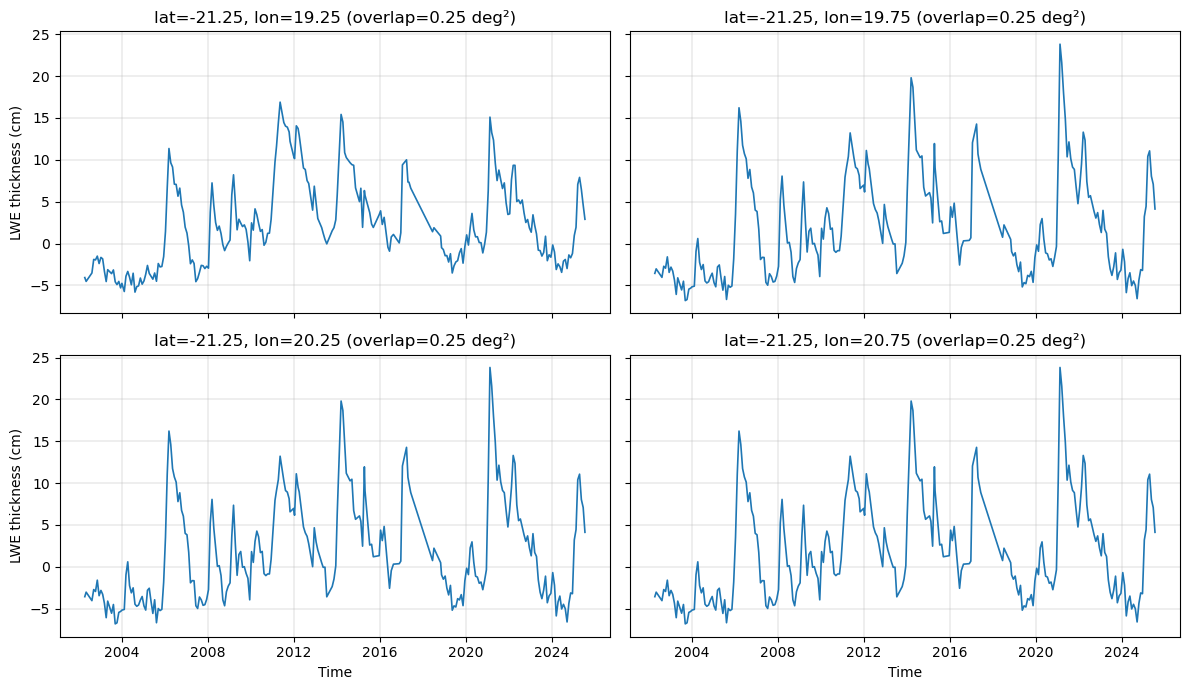

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from shapely.prepared import prep

# --- GRACE variable ---
da = ds["lwe_thickness"]  # (time, lat, lon)

# --- your Okavango polygon (in your notebook this is the bbox polygon) ---
poly_okavango = Polygon(okavango)  # lon/lat corners
P = prep(poly_okavango)

# --- infer grid spacing (~1 deg) ---
dlon = float(np.median(np.abs(np.diff(da["lon"].values))))
dlat = float(np.median(np.abs(np.diff(da["lat"].values))))

# --- subset to polygon bounds (+ half-cell padding) ---
min_lon, min_lat, max_lon, max_lat = poly_okavango.bounds
pad_lon, pad_lat = dlon/2, dlat/2

lon_slice = slice(min_lon - pad_lon, max_lon + pad_lon)

lat_vals = da["lat"].values
if lat_vals[0] > lat_vals[-1]:   # descending
    lat_slice = slice(max_lat + pad_lat, min_lat - pad_lat)
else:                            # ascending
    lat_slice = slice(min_lat - pad_lat, max_lat + pad_lat)

da_sub = da.sel(lon=lon_slice, lat=lat_slice)

# --- compute overlap area for each 1° cell footprint; keep top 4 ---
lons = da_sub["lon"].values
lats = da_sub["lat"].values

cells = []
for lat in lats:
    y0, y1 = float(lat - dlat/2), float(lat + dlat/2)
    for lon in lons:
        x0, x1 = float(lon - dlon/2), float(lon + dlon/2)
        cell_poly = box(x0, y0, x1, y1)
        if P.intersects(cell_poly):
            a = poly_okavango.intersection(cell_poly).area  # degree^2
            cells.append((a, float(lat), float(lon)))

cells = sorted(cells, reverse=True, key=lambda t: t[0])
top4 = cells[:4]

print("Selected 4 cells (overlap_area, lat_center, lon_center):")
for a, lat, lon in top4:
    print(f"{a:.3f}, {lat:.3f}, {lon:.3f}")

# --- plot each cell separately (2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (a, lat, lon) in zip(axes, top4):
    y = da_sub.sel(lat=lat, lon=lon)
    ax.plot(y["time"].values, y.values, lw=1.2)
    ax.set_title(f"lat={lat:.2f}, lon={lon:.2f} (overlap={a:.2f} deg²)")
    ax.grid(True, linewidth=0.3)

axes[0].set_ylabel("LWE thickness (cm)")
axes[2].set_ylabel("LWE thickness (cm)")
for ax in axes[2:]:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


In [13]:
y

<xarray.DataArray 'lwe_thickness' (time: 247)>
array([-3.564974, -3.023124, -4.039032, ...,  8.040765,  7.088303,  4.12291 ])
Coordinates:
    lon      float64 20.75
    lat      float64 -21.25
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2025-07-16T12:00:00
Attributes:
    units:          cm
    long_name:      Liquid_Water_Equivalent_Thickness
    standard_name:  Liquid_Water_Equivalent_Thickness
    grid_mapping:   WGS84
    valid_min:      -2233.2482913956046
    valid_max:      1138.1877254893382
    comment:        Coastline Resolution Improvement (CRI) filter is applied

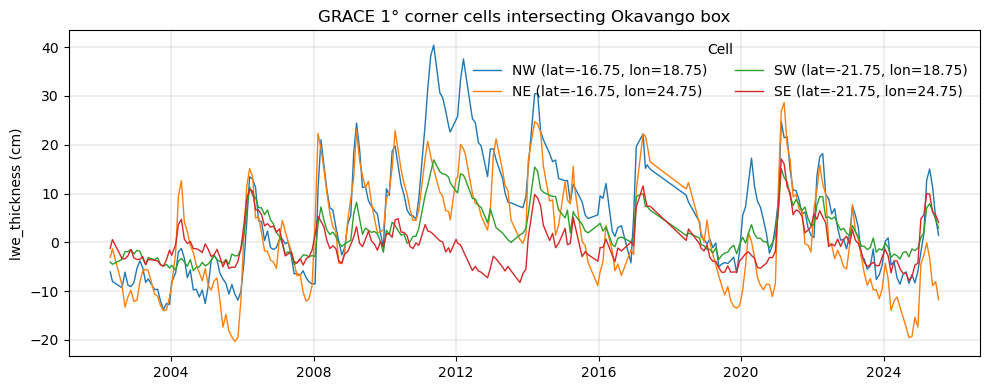

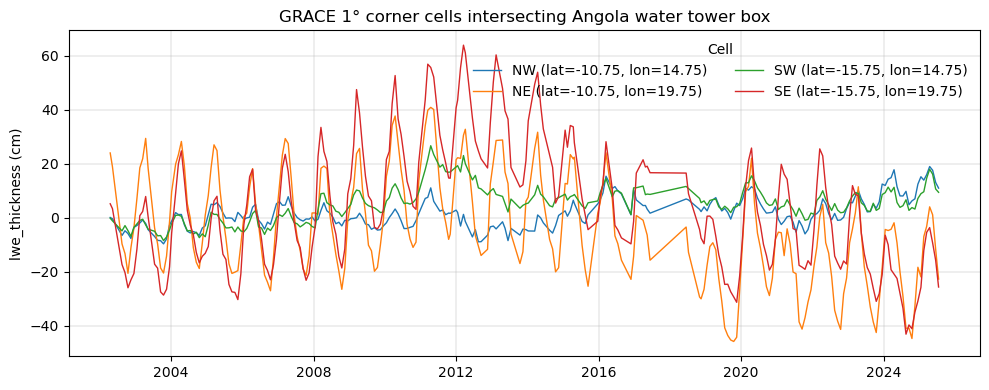

{'NW': (-10.75, 14.75),
 'NE': (-10.75, 19.75),
 'SW': (-15.75, 14.75),
 'SE': (-15.75, 19.75)}

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from shapely.prepared import prep

def plot_4corner_cells(da, corners_lonlat, title):
    """
    Pick the 4 *corner* 1° cells intersecting a polygon:
      NW = (max lat, min lon), NE = (max lat, max lon),
      SW = (min lat, min lon), SE = (min lat, max lon)
    and plot them on one axis with a legend.
    """
    poly = Polygon(corners_lonlat)
    P = prep(poly)

    # grid spacing (deg)
    lons = da["lon"].values
    lats = da["lat"].values
    dlon = float(np.median(np.abs(np.diff(lons))))
    dlat = float(np.median(np.abs(np.diff(lats))))

    # subset to poly bounds (+ half-cell pad)
    min_lon, min_lat, max_lon, max_lat = poly.bounds
    pad_lon, pad_lat = dlon / 2, dlat / 2

    lon_slice = slice(min_lon - pad_lon, max_lon + pad_lon)
    if lats[0] > lats[-1]:  # descending
        lat_slice = slice(max_lat + pad_lat, min_lat - pad_lat)
    else:                   # ascending
        lat_slice = slice(min_lat - pad_lat, max_lat + pad_lat)

    da_sub = da.sel(lon=lon_slice, lat=lat_slice)

    # candidate intersecting cells (use full 1° footprint)
    cand = []  # (lat_center, lon_center, overlap_area)
    for lat in da_sub["lat"].values:
        for lon in da_sub["lon"].values:
            cell = box(float(lon - dlon/2), float(lat - dlat/2),
                       float(lon + dlon/2), float(lat + dlat/2))
            if P.intersects(cell):
                overlap = poly.intersection(cell).area
                cand.append((float(lat), float(lon), float(overlap)))

    if not cand:
        raise ValueError("No intersecting cells found for this polygon.")

    cand = np.array(cand)  # cols: lat, lon, overlap
    lat_n, lat_s = cand[:, 0].max(), cand[:, 0].min()
    lon_w, lon_e = cand[:, 1].min(), cand[:, 1].max()

    targets = {"NW": (lat_n, lon_w), "NE": (lat_n, lon_e),
               "SW": (lat_s, lon_w), "SE": (lat_s, lon_e)}

    picked = {}
    for lab, (tlat, tlon) in targets.items():
        d2 = (cand[:, 0] - tlat) ** 2 + (cand[:, 1] - tlon) ** 2
        idxs = np.where(d2 == d2.min())[0]
        idx = idxs[np.argmax(cand[idxs, 2])]  # tie-break by overlap
        picked[lab] = (cand[idx, 0], cand[idx, 1])

    if len(set(picked.values())) < 4:
        print("Warning: fewer than 4 unique corner cells (region may span only 1 row/col at this grid).")
        print("Picked:", picked)

    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    for lab in ["NW", "NE", "SW", "SE"]:
        lat, lon = picked[lab]
        y = da.sel(lat=lat, lon=lon)
        ax.plot(y["time"].values, y.values, lw=1.,
                label=f"{lab} (lat={lat:.2f}, lon={lon:.2f})")

    ax.set_title(title)
    ax.set_ylabel(f"{da.name} ({da.attrs.get('units','')})".strip())
    ax.grid(True, linewidth=0.3)
    ax.legend(ncol=2, frameon=False, title="Cell")
    plt.tight_layout()
    plt.show()

    return picked


# --- Okavango ---
plot_4corner_cells(ds["lwe_thickness"], okavango,
                   "GRACE 1° corner cells intersecting Okavango box")

# --- Highlands (your notebook calls this Angola water tower) ---
plot_4corner_cells(ds["lwe_thickness"], angola_water_tower,
                   "GRACE 1° corner cells intersecting Angola water tower box")


In [15]:
import numpy as np
import pandas as pd

def plot_with_gap_breaks(ax, t, y, gap_days=45, **plot_kwargs):
    """
    Plot (t, y) but insert NaNs anywhere there's a big time gap so the line breaks.
    - gap_days: any gap larger than this (in days) triggers a break
    """
    t = pd.to_datetime(t)
    y = np.asarray(y, dtype=float)

    t2 = [t[0]]
    y2 = [y[0]]

    for i in range(1, len(t)):
        dt_days = (t[i] - t[i-1]).days
        if dt_days > gap_days:
            # insert a NaN point between segments
            t2.append(t[i-1] + (t[i] - t[i-1]) / 2)
            y2.append(np.nan)
        t2.append(t[i])
        y2.append(y[i])

    ax.plot(t2, y2, **plot_kwargs)


grid spacing (deg): 0.5 0.5
candidate grid points: 121
unique blocks (should be 6): 6


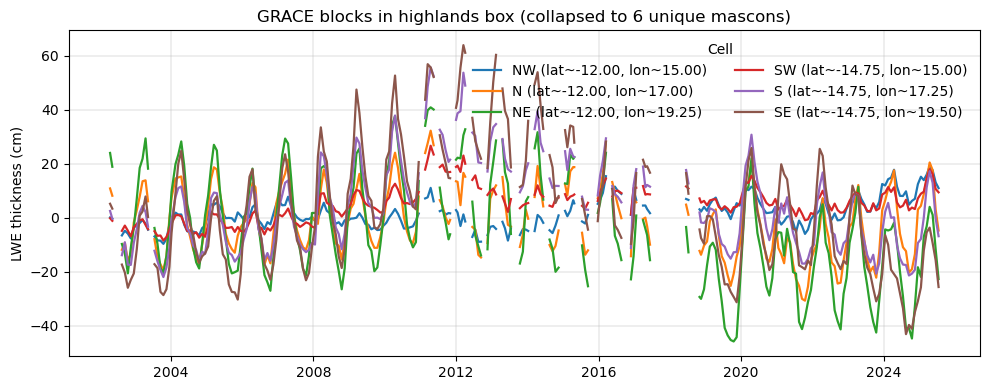

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from collections import defaultdict
from shapely.geometry import Polygon

da = ds["lwe_thickness"]                 # (time, lat, lon)
highlands_poly = Polygon(angola_water_tower)  # box corners (lon,lat)

# --- grid spacing (deg) ---
dlat = float(np.median(np.abs(np.diff(da["lat"].values))))
dlon = float(np.median(np.abs(np.diff(da["lon"].values))))
print("grid spacing (deg):", dlat, dlon)

# --- select all grid cells whose *footprints* overlap the highlands box ---
min_lon, min_lat, max_lon, max_lat = highlands_poly.bounds
lons_sel = da["lon"].where((da["lon"] >= min_lon - dlon/2) & (da["lon"] <= max_lon + dlon/2), drop=True)
lats_sel = da["lat"].where((da["lat"] >= min_lat - dlat/2) & (da["lat"] <= max_lat + dlat/2), drop=True)
da_box = da.sel(lon=lons_sel, lat=lats_sel)

# --- stack to (time, cell) ---
ts = da_box.stack(cell=("lat", "lon")).transpose("time", "cell").dropna("cell", how="all")
cell_index = ts["cell"].to_index()  # MultiIndex (lat, lon)
arr = ts.values                      # shape (time, ncell)

print("candidate grid points:", arr.shape[1])

# --- group by identical time series (mascon blocks) ---
groups = defaultdict(list)
for i in range(arr.shape[1]):
    v = np.round(arr[:, i].astype("float64"), 6)
    v = np.where(np.isnan(v), -9999.0, v)  # stable hashing if any NaNs
    key = hashlib.md5(v.tobytes()).hexdigest()
    groups[key].append(i)

print("unique blocks (should be 6):", len(groups))

# representative + centroid per block
blocks = []
for key, idxs in groups.items():
    lats = np.array([cell_index[j][0] for j in idxs], dtype=float)
    lons = np.array([cell_index[j][1] for j in idxs], dtype=float)
    lat_c = float(lats.mean())
    lon_c = float(lons.mean())
    rep = idxs[0]  # any member works (series are identical)
    blocks.append((lat_c, lon_c, rep))

# --- label blocks like your map: NW, N, NE / SW, S, SE (for 6 blocks) ---
blocks = sorted(blocks, key=lambda t: (-t[0], t[1]))  # north->south, west->east

label_for_rep = {}
if len(blocks) == 6:
    north = sorted(blocks[:3], key=lambda t: t[1])
    south = sorted(blocks[3:], key=lambda t: t[1])
    for lab, (_, _, rep) in zip(["NW", "N", "NE"], north): label_for_rep[rep] = lab
    for lab, (_, _, rep) in zip(["SW", "S", "SE"], south): label_for_rep[rep] = lab
else:
    # fallback: just number them in map order
    for k, (_, _, rep) in enumerate(blocks, 1):
        label_for_rep[rep] = f"Block{k}"

# --- plot all 6 on one axis ---
fig, ax = plt.subplots(figsize=(10, 4))

# stable plotting order by label
order = {"NW":0, "N":1, "NE":2, "SW":3, "S":4, "SE":5}
for lat_c, lon_c, rep in sorted(blocks, key=lambda t: order.get(label_for_rep[t[2]], 99)):
    y = ts.isel(cell=rep)
    lab = label_for_rep[rep]
    plot_with_gap_breaks(ax,y["time"].values, y.values, lw=1.6,
            label=f"{lab} (lat~{lat_c:.2f}, lon~{lon_c:.2f})")

ax.set_title("GRACE blocks in highlands box (collapsed to 6 unique mascons)")
ax.set_ylabel("LWE thickness (cm)")
ax.grid(True, linewidth=0.3)
ax.legend(ncol=2, frameon=False, title="Cell")
plt.tight_layout()
plt.show()


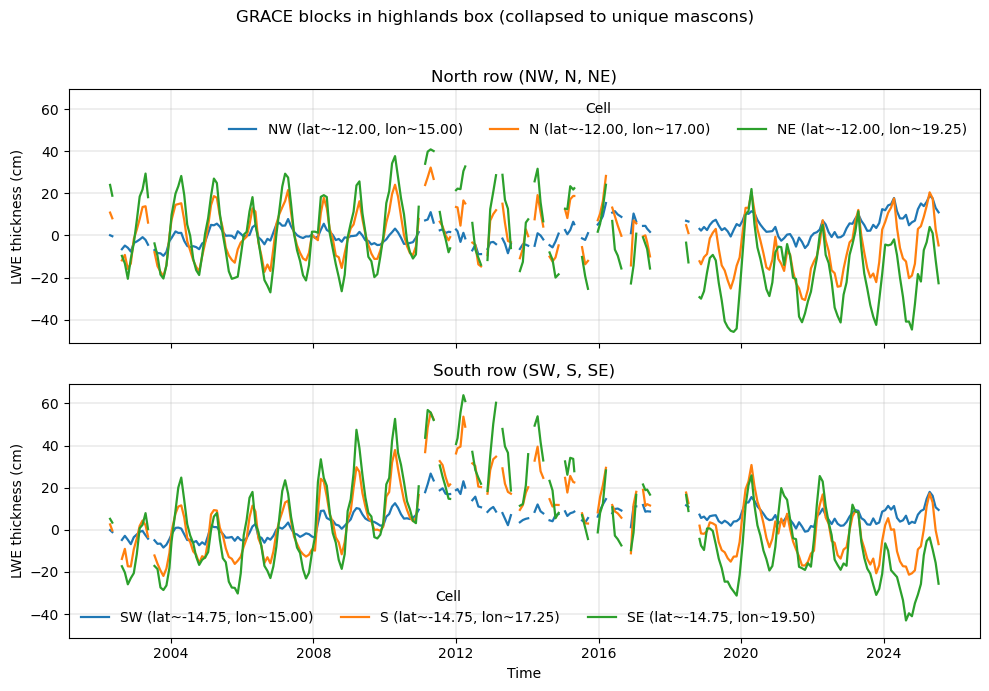

In [17]:
# --- plot north and south rows in two subplots ---
fig, (axN, axS) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# collect metadata for plotting
entries = []
for lat_c, lon_c, rep in blocks:
    lab = label_for_rep[rep]
    entries.append((lab, lat_c, lon_c, rep))

# split into north vs south using labels when available
north = [e for e in entries if str(e[0]).startswith("N")]  # NW, N, NE
south = [e for e in entries if str(e[0]).startswith("S")]  # SW, S, SE

# fallback if labels aren't NW/N/NE etc (e.g., Block1..): split by median latitude
if (len(north) == 0) or (len(south) == 0):
    lat_med = np.median([lat_c for _, lat_c, _, _ in entries])
    north = [e for e in entries if e[1] >= lat_med]
    south = [e for e in entries if e[1] <  lat_med]

# stable within-row order
north_order = {"NW": 0, "N": 1, "NE": 2}
south_order = {"SW": 0, "S": 1, "SE": 2}

north = sorted(north, key=lambda e: north_order.get(e[0], 99))
south = sorted(south, key=lambda e: south_order.get(e[0], 99))

# plot north row
for lab, lat_c, lon_c, rep in north:
    y = ts.isel(cell=rep)
    plot_with_gap_breaks(
        axN,
        y["time"].values,
        y.values,
        lw=1.6,
        label=f"{lab} (lat~{lat_c:.2f}, lon~{lon_c:.2f})"
    )

# plot south row
for lab, lat_c, lon_c, rep in south:
    y = ts.isel(cell=rep)
    plot_with_gap_breaks(
        axS,
        y["time"].values,
        y.values,
        lw=1.6,
        label=f"{lab} (lat~{lat_c:.2f}, lon~{lon_c:.2f})"
    )

axN.set_title("North row (NW, N, NE)")
axS.set_title("South row (SW, S, SE)")

axN.set_ylabel("LWE thickness (cm)")
axS.set_ylabel("LWE thickness (cm)")
axS.set_xlabel("Time")

axN.grid(True, linewidth=0.3)
axS.grid(True, linewidth=0.3)

axN.legend(ncol=3, frameon=False, title="Cell")
axS.legend(ncol=3, frameon=False, title="Cell")

fig.suptitle("GRACE blocks in highlands box (collapsed to unique mascons)", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



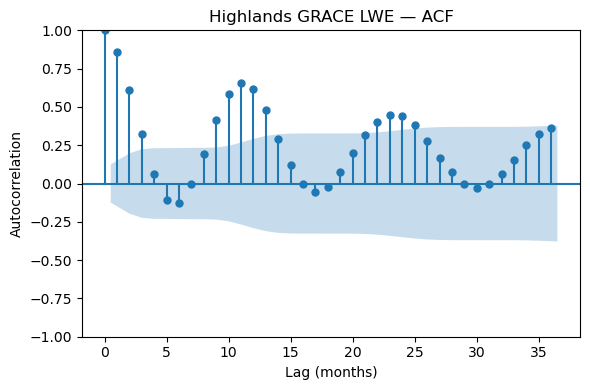

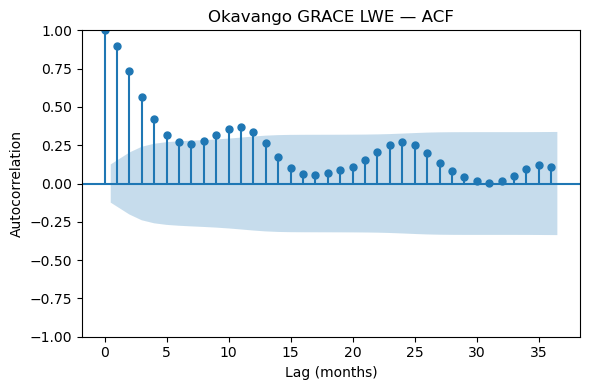

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_grace_acf(df, col="lwe_mean_cm", lags=36, title=None):
    """Plot autocorrelation function for a GRACE LWE time series."""
    y = df[col].dropna()

    fig, ax = plt.subplots(figsize=(6, 4))
    plot_acf(y, lags=lags, ax=ax)
    ax.set_xlabel("Lag (months)")
    ax.set_ylabel("Autocorrelation")

    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Examples:
plot_grace_acf(highland_grace, title="Highlands GRACE LWE — ACF")
plot_grace_acf(ok_grace,       title="Okavango GRACE LWE — ACF")
# BUILT IN FUNCTION. NOT SURE WHAT SHADING MEANS.

Highlands GRACE — 12-month harmonic
  R²:        0.531
  Amplitude: 13.435 cm
  Phase:     -1.778 radians


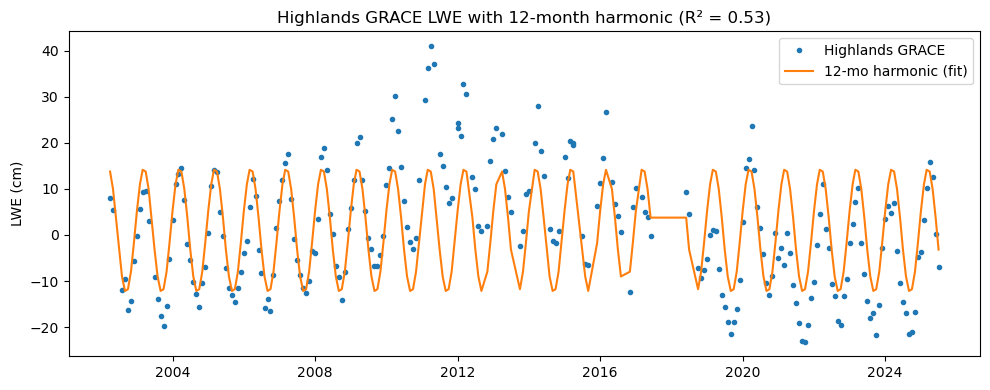

Okavango GRACE — 12-month harmonic
  R²:        0.199
  Amplitude: 5.028 cm
  Phase:     -1.897 radians


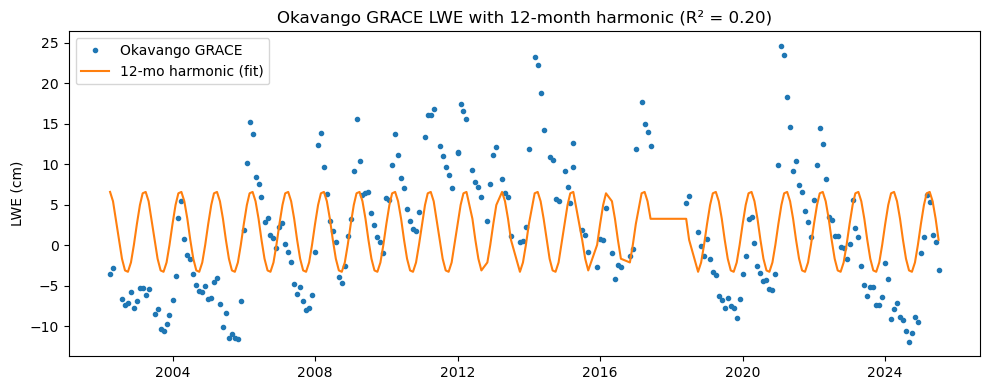

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def fit_annual_harmonic(df, col="lwe_mean_cm", period_months=12, label="GRACE"):
    """
    Fit a single-period harmonic (e.g., 12-month) to a monthly time series.

    Returns
    -------
    results : dict
        Contains r2, amplitude, phase, intercept, a1, b1, t, y, y_hat.
    """
    g = df.copy()
    g["date"] = pd.to_datetime(g["date"])
    g = g.sort_values("date")

    # fractional month index starting at 0
    t = (g["date"].dt.year - g["date"].dt.year.min()) * 12 + g["date"].dt.month
    t = t.values.astype(float)

    y = g[col].values

    # --- harmonic regressors
    omega = 2 * np.pi / period_months
    X = np.column_stack([
        np.ones_like(t),
        np.cos(omega * t),
        np.sin(omega * t),
    ])

    # --- fit
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(X)

    # --- R² and harmonic parameters
    r2 = m.score(X, y)
    a1 = m.coef_[1]
    b1 = m.coef_[2]
    amplitude = np.sqrt(a1**2 + b1**2)
    phase = np.arctan2(-b1, a1)  # conventional phase convention

    print(f"{label} — {period_months}-month harmonic")
    print(f"  R²:        {r2:.3f}")
    print(f"  Amplitude: {amplitude:.3f} cm")
    print(f"  Phase:     {phase:.3f} radians")

    # --- plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(g["date"], y, ".", label=label)
    ax.plot(g["date"], y_hat, "-", label=f"{period_months}-mo harmonic (fit)")
    ax.legend()
    ax.set_ylabel("LWE (cm)")
    ax.set_title(f"{label} LWE with {period_months}-month harmonic (R² = {r2:.2f})")
    plt.tight_layout()
    plt.show()

    return {
        "r2": r2,
        "amplitude": amplitude,
        "phase": phase,
        "intercept": m.intercept_,
        "a1": a1,
        "b1": b1,
        "t": t,
        "y": y,
        "y_hat": y_hat,
    }

# Examples:

highland_harm = fit_annual_harmonic(highland_grace, label="Highlands GRACE")
okavango_harm = fit_annual_harmonic(ok_grace, label="Okavango GRACE")


In [22]:

annual_km2 = pd.read_csv("../data/annual_flood_area_km2.csv")

In [23]:
annual_km2 = annual_km2.query('year > 2002')

In [24]:
annual_km2.head()

,Unnamed: 0,year,landsat_jas_mean_km2,landsat_max_km2,sentinel_jas_mean_km2,il_annual_km2
18,18,2003,NaN,5275.422353,NaN,5329.175005
19,19,2004,8177.177698,8576.278048,NaN,8208.494658
20,20,2005,6524.921972,7108.297948,NaN,6917.729975
21,21,2006,7289.875480,7848.245276,NaN,7425.152908
22,22,2007,8225.249864,8476.004739,NaN,8476.415905


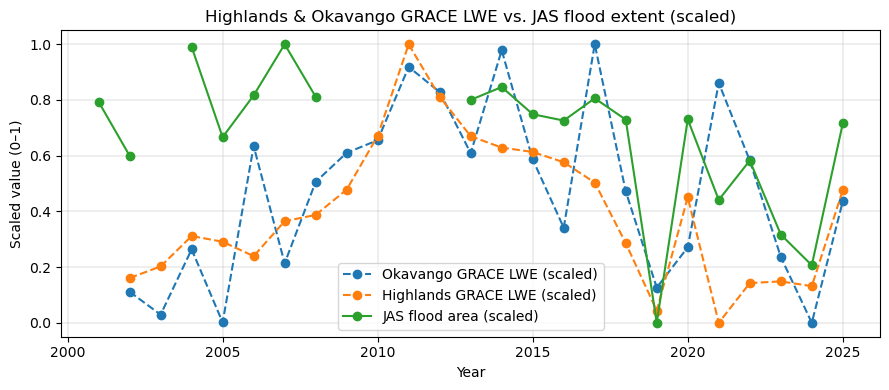

In [25]:
def rescale_to_unit_interval(series):
    """Rescale a pandas Series to [0, 1], ignoring NaNs."""
    s = series.astype(float)
    s_min = np.nanmin(s)
    s_max = np.nanmax(s)
    return (s - s_min) / (s_max - s_min)

# 1) Annual means for Okavango and Highlands
ok_grace_year_ = (
    ok_grace
    .copy()
    .assign(year=lambda df: df["date"].dt.year)
    .groupby("year", as_index=False)[["lwe_mean_cm"]]
    .mean(numeric_only=True)
    .rename(columns={"lwe_mean_cm": "ok_lwe_mean_cm"})
)

highland_grace_year_ = (
    highland_grace
    .copy()
    .assign(year=lambda df: df["date"].dt.year)
    .groupby("year", as_index=False)[["lwe_mean_cm"]]
    .mean(numeric_only=True)
    .rename(columns={"lwe_mean_cm": "highland_lwe_mean_cm"})
)

# 2) Load flood area (Okavango JAS DSWE)
annual_km2 = pd.read_csv("../data/annual_flood_area_km2.csv")
# assume column 'landsat_jas_mean_km2' exists

# 3) Merge everything on year
merged = (
    ok_grace_year_
    .merge(highland_grace_year_, on="year", how="outer")
    .merge(annual_km2, on="year", how="outer")
    .sort_values("year")
    .query("year > 2000")
    .reset_index(drop=True)
)

# 4) Rescale each series to [0, 1]
scaled_ok       = rescale_to_unit_interval(merged["ok_lwe_mean_cm"])
scaled_highland = rescale_to_unit_interval(merged["highland_lwe_mean_cm"])
scaled_flood    = rescale_to_unit_interval(merged["landsat_jas_mean_km2"])

# 5) Plot
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(merged["year"], scaled_ok,       "o--", label="Okavango GRACE LWE (scaled)")
ax.plot(merged["year"], scaled_highland, "o--", label="Highlands GRACE LWE (scaled)")
ax.plot(merged["year"], scaled_flood,    "o-",  label="JAS flood area (scaled)")

ax.set_xlabel("Year")
ax.set_ylabel("Scaled value (0–1)")
ax.set_title("Highlands & Okavango GRACE LWE vs. JAS flood extent (scaled)")
ax.grid(True, linewidth=0.3)
ax.legend()
plt.tight_layout()
plt.show()


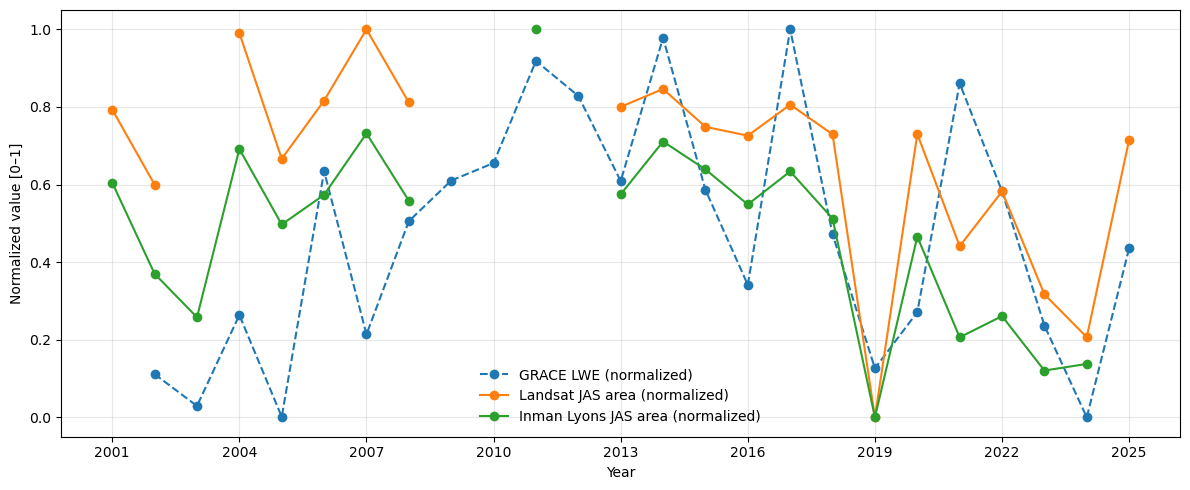

In [26]:
from matplotlib.ticker import MaxNLocator


def normalize(a):
    a = np.asarray(a, dtype=float)
    # Robust min-max with constant-array guard
    amin = np.nanmin(a)
    amax = np.nanmax(a)
    rng = amax - amin
    if not np.isfinite(rng) or rng == 0:
        return np.zeros_like(a)  # all same value → flat line at 0
    return (a - amin) / rng

# Extract
gy_year  = ok_grace_year["year"]
gy_value = ok_grace_year["lwe_mean_cm"]

ls_year  = merged["year"]
ls_value = merged["landsat_jas_mean_km2"]
il_value = merged["il_annual_km2"]

# Build tidy DataFrame for easy NA filtering & alignment
df_grace = pd.DataFrame({"year": gy_year, "grace": gy_value}).dropna().drop_duplicates(subset=["year"])
df_ls    = pd.DataFrame({"year": ls_year, "landsat": ls_value}).dropna().drop_duplicates(subset=["year"])
df_il    = pd.DataFrame({"year": ls_year, "il": il_value}).dropna().drop_duplicates(subset=["year"])


# (Optional) inner-join to compare only overlapping years; switch to outer if you want all years
df = pd.merge(df_grace, df_ls, on="year", how="outer").sort_values("year")
df = pd.merge(df, df_il, on="year", how="outer").sort_values("year")

# Normalize columns independently to [0, 1]
df["grace_n"]   = normalize(df["grace"])
df["landsat_n"] = normalize(df["landsat"])
df["il_n"] = normalize(df["il"])

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df["year"], df["grace_n"],   marker="o", linestyle="--", label="GRACE LWE (normalized)")
ax.plot(df["year"], df["landsat_n"], marker="o", linestyle="-",  label="Landsat JAS area (normalized)")
ax.plot(df["year"], df["il_n"], marker="o", linestyle="-",  label="Inman Lyons JAS area (normalized)")

# Cosmetics
ax.set_xlabel("Year")
ax.set_ylabel("Normalized value [0–1]")
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
plt.show()


In [27]:
merged.query('year > 2004')[['landsat_jas_mean_km2', 'il_annual_km2',  
                             'landsat_max_km2', 'ok_lwe_mean_cm',]].corr().round(2)

,landsat_jas_mean_km2,il_annual_km2,landsat_max_km2,ok_lwe_mean_cm
landsat_jas_mean_km2,1.00,0.96,0.89,0.43
il_annual_km2,0.96,1.00,0.79,0.51
landsat_max_km2,0.89,0.79,1.00,0.57
ok_lwe_mean_cm,0.43,0.51,0.57,1.00


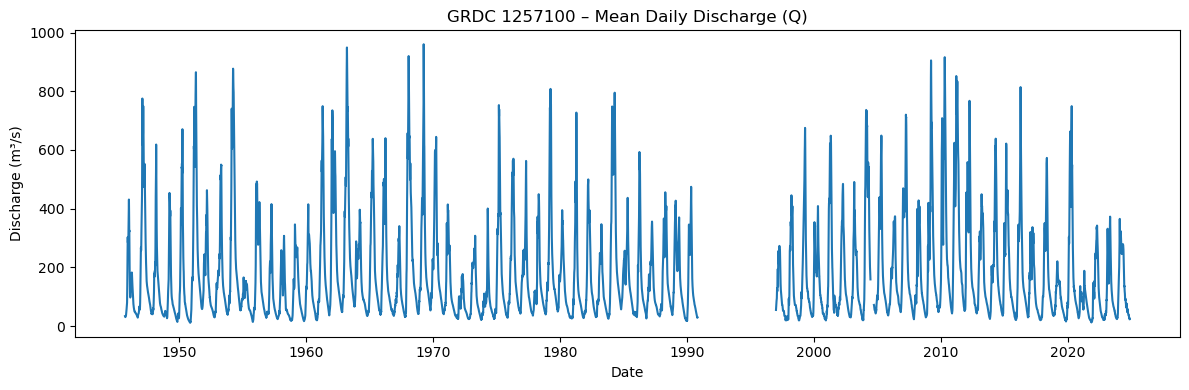

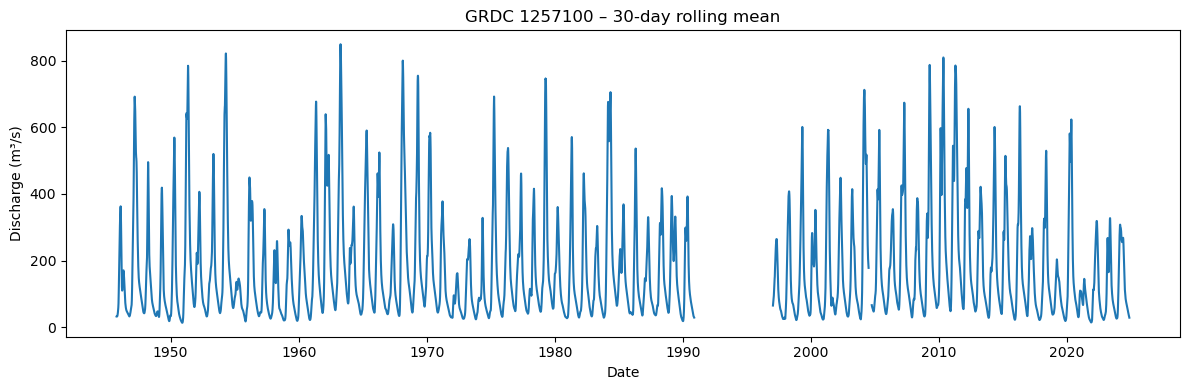

In [28]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# ---- file path (edit as needed) ----
path = Path("../GRDC_station_data/1257100_Q_Day.Cmd.txt")

# ---- read ----
df = pd.read_csv(
    path,
    sep=";",                 # semicolon-delimited
    comment="#",             # skip metadata/header lines starting with '#'
    skipinitialspace=True,   # handles "YYYY-MM-DD;hh:mm; Value" / padded numbers
    encoding="latin-1",      # avoids UnicodeDecodeError from superscripts like ³, ²
    na_values=[-999.000, "-999.000"],  # missing sentinel
)


# Clean column names (e.g., " Value" -> "Value")
df.columns = [c.strip() for c in df.columns]

# Ensure numeric values
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

# Build a datetime index.
# For daily data, hh:mm is often "--:--" (unknown), so map it to midnight.
time_str = df["hh:mm"].astype(str).replace({"--:--": "00:00"})
df["datetime"] = pd.to_datetime(
    df["YYYY-MM-DD"].astype(str) + " " + time_str,
    errors="coerce",
)

# Index by datetime and sort
df = df.dropna(subset=["datetime"]).set_index("datetime").sort_index()

q = df["Value"]  # discharge (m³/s)

# ---- plot 1: raw daily series ----
plt.figure(figsize=(12, 4))
plt.plot(q.index, q.values)
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("GRDC 1257100 – Mean Daily Discharge (Q)")
plt.tight_layout()
plt.show()

# ---- plot 2 (optional): smoothed curve (30-day rolling mean) ----
plt.figure(figsize=(12, 4))
plt.plot(q.index, q.rolling(30, min_periods=10).mean())
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("GRDC 1257100 – 30-day rolling mean")
plt.tight_layout()
plt.show()


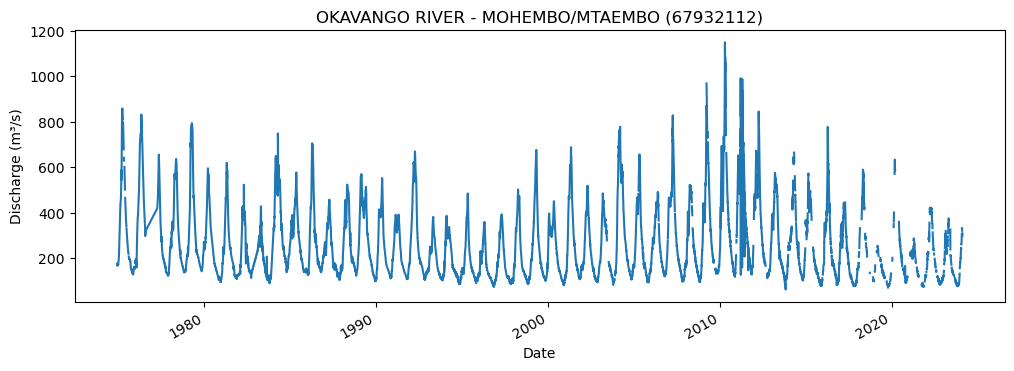

In [29]:
from __future__ import annotations

from pathlib import Path
import re
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MISSING_SENTINEL = -999.000


def extract_grdc_metadata(path: str | Path, encoding: str = "cp1252") -> dict:
    """
    Extract key/value metadata from the GRDC header (lines starting with '#').

    Notes:
      - This file contains superscript chars like 'm³/s' and 'km²'. In practice,
        'cp1252' or 'latin1' is usually safe for these GRDC text exports.
    """
    path = Path(path)
    meta: dict = {}
    header_lines: list[str] = []

    # Read header lines (start with '#') until the first non-header line
    with path.open("r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                break
            header_lines.append(line.rstrip("\n"))

    meta["_raw_header"] = header_lines  # keep if you want to inspect the full header

    # Parse "# Key: Value" lines
    kv_re = re.compile(r"^#\s*([^:]+):\s*(.*)$")
    for ln in header_lines:
        # Ignore indented comment lines (e.g. table header lines like "#     hh:mm - Time")
        if re.match(r"^#\s{2,}\S", ln):
            continue

        m = kv_re.match(ln)
        if not m:
            continue

        key = m.group(1).strip()
        val = re.sub(r"\s{2,}", " ", m.group(2).strip())  # collapse multiple spaces
        meta[key] = val

    # Light type coercions for common numeric/date fields
    def maybe_number(x: str):
        try:
            n = float(x)
            return int(n) if n.is_integer() else n
        except Exception:
            return x

    for k in [
        "GRDC-No.",
        "Next downstream station",
        "Data lines",
        "No. of years",
        "Latitude (DD)",
        "Longitude (DD)",
        "Catchment area (km²)",
        "Altitude (m ASL)",
    ]:
        if k in meta:
            meta[k] = maybe_number(str(meta[k]))

    for k in ["file generation date", "Last update"]:
        if k in meta:
            try:
                meta[k] = date.fromisoformat(str(meta[k]))
            except Exception:
                pass

    # Optional: include filesystem-level metadata too
    st = path.stat()
    meta["_file_name"] = path.name
    meta["_file_size_bytes"] = st.st_size
    meta["_file_mtime_utc"] = pd.to_datetime(st.st_mtime, unit="s", utc=True)

    return meta


def read_grdc_timeseries(path: str | Path, encoding: str = "cp1252") -> pd.DataFrame:
    """
    Read the GRDC data section into a DataFrame with a DatetimeIndex.
    """
    path = Path(path)

    df = pd.read_csv(path, sep=";", comment="#", encoding=encoding)
    df.columns = [c.strip() for c in df.columns]  # e.g. " Value" -> "Value"

    # Convert value and apply missing sentinel
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce").replace(MISSING_SENTINEL, np.nan)

    # For daily values GRDC often uses "--:--" in the time column; treat it as midnight.
    time = df["hh:mm"].astype(str).str.strip().replace({"--:--": "00:00"})

    df["datetime"] = pd.to_datetime(
        df["YYYY-MM-DD"].astype(str).str.strip() + " " + time,
        errors="coerce",
    )

    df = df.dropna(subset=["datetime"]).set_index("datetime").sort_index()
    return df


def plot_grdc_timeseries(df: pd.DataFrame, meta: dict) -> None:
    """
    Simple timeseries plot.
    """
    unit = meta.get("Unit of measure", "")
    river = meta.get("River", "")
    station = meta.get("Station", "")
    title = " - ".join([x for x in [river, station] if x])

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df["Value"])
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Discharge ({unit})" if unit else "Discharge")
    if title:
        ax.set_title(title)
    fig.autofmt_xdate()
    plt.show()



PATH = "../GRDC_station_data/1357100_Q_Day.Cmd.txt"  # <- change if needed

meta = extract_grdc_metadata(PATH)
df = read_grdc_timeseries(PATH)

# Add a few derived metadata fields from the actual data read
meta["_rows_read"] = len(df)
meta["_missing_values"] = int(df["Value"].isna().sum())
meta["_date_min"] = df.index.min().date().isoformat()
meta["_date_max"] = df.index.max().date().isoformat()

# # Print metadata (skip the raw header unless you want it)
# print("---- METADATA ----")
# for k in sorted([k for k in meta.keys() if k != "_raw_header"]):
#     print(f"{k}: {meta[k]}")

# Plot
plot_grdc_timeseries(df, meta)


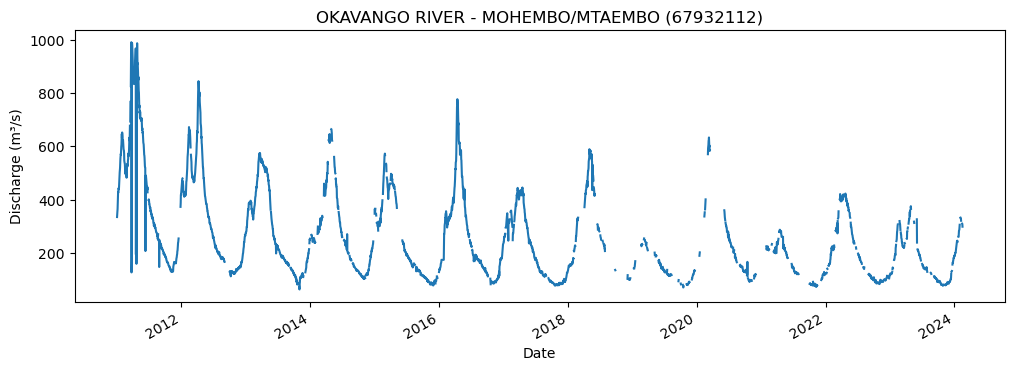

In [30]:
df['avg'] = df["Value"].rolling("30D", min_periods=10).mean()
df['month'] = df.index.month
df['year'] = df.index.year
plot_grdc_timeseries(df.query("year > 2010"), meta)

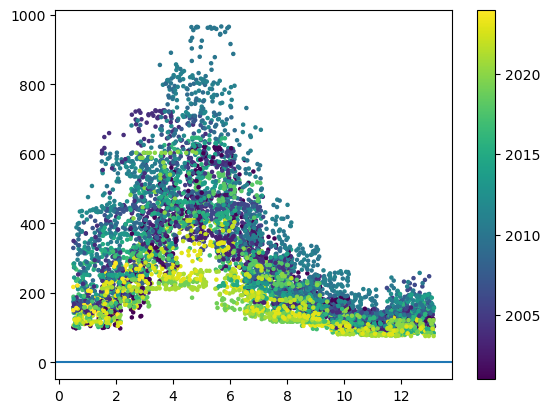

In [31]:
dff = df.sort_values('Value').query(" year > 2000")

plt.scatter(np.random.rand(len(dff))/.6 + dff['month'] -.5, (dff['avg']), s = 5, c = dff.year)
plt.colorbar()
plt.axhline(0)

In [32]:
# !open  "../GRDC_station_data/1357100_Q_Day.Cmd.txt" 